In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [526]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.style.use('seaborn-whitegrid')

In [527]:
year = '19'

Open data files and transform them into pandas dataframe

In [528]:
f = uproot.pandas.iterate("../outputs/"+year+"/*.root", "t", 
                          branches=['label', 'beam_energy', 'mass', 'trigger', 'procedure'])
data = pd.concat([j for j in f])

Sort values by label

In [529]:
data.sort_values(by='label', ascending=True, inplace=True);

Cut off incorrect beam energy and mass outside the window

In [530]:
data.query('beam_energy>0&mass>450&mass<550&procedure!=1', inplace=True)
if not(year=='model'):
    data.query('trigger>-1', inplace=True)

Change index column

In [531]:
data.index = data.label
data.drop(['label', 'procedure'], axis=1, inplace=True)

Include luminosity file

In [532]:
lum = pd.read_csv('../inputs/'+year+'/lum')
lum.columns = ['label', 'lum', 'lum_err']

In [533]:
lum = lum.drop_duplicates(subset=['label'])

In [534]:
lum.index = lum.label
lum.drop(['label'], axis=1, inplace=True)

In [535]:
lum.shape

(44, 2)

In [536]:
lum.head()

,lum,lum_err
label,,
550.1,496.833,1.14065
550.0,1424.270,1.93920
537.5,1224.660,1.75856
562.5,1048.680,1.70440
575.0,1054.350,1.74597


Check right values of triggers

In [537]:
data.groupby('trigger').agg({'mass':np.size})

,mass
trigger,
0,1256.0
1,224.0
2,8203.0


In [538]:
data.head()

,beam_energy,mass,trigger
label,,,
537.5,537.454102,496.262360,2
537.5,537.454102,497.135071,2
537.5,537.454102,496.744629,2
537.5,537.454102,497.835114,0
537.5,537.454102,494.808807,2


In [539]:
lum.sort_index()

,lum,lum_err
label,,
537.5,1224.660,1.75856
550.0,1424.270,1.93920
550.1,496.833,1.14065
562.5,1048.680,1.70440
575.0,1054.350,1.74597
587.5,1167.380,1.87792
600.0,1161.830,1.90969
612.5,1059.040,1.86299
612.6,1179.140,1.96537


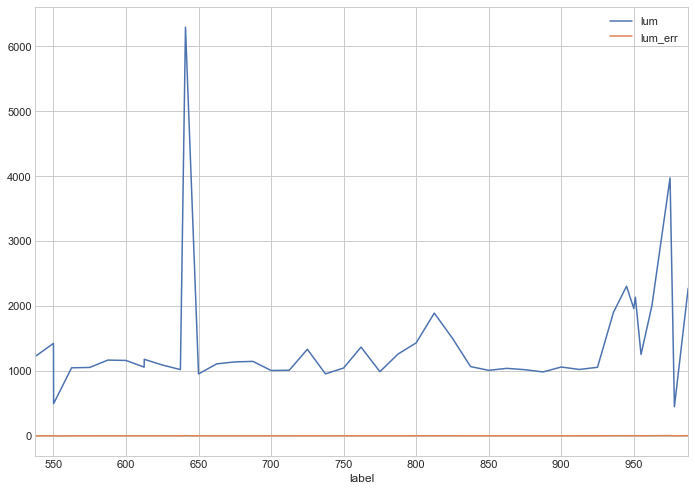

In [540]:
lum.sort_index().plot()

Join luminosity to data file

In [541]:
data = data.join(lum, how='inner')

In [542]:
lum.drop_duplicates().sort_index().head()

,lum,lum_err
label,,
537.5,1224.660,1.75856
550.0,1424.270,1.93920
550.1,496.833,1.14065
562.5,1048.680,1.70440
575.0,1054.350,1.74597


See how much events in each point I have

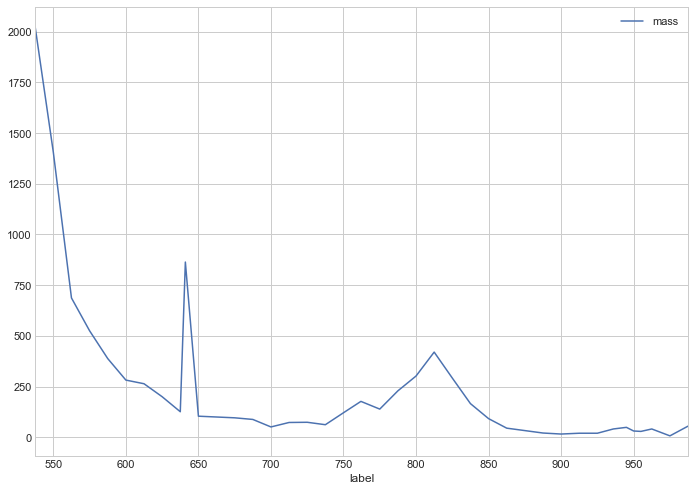

In [543]:
data.groupby('label').agg({'mass':np.size}).plot()

In [544]:
data.groupby('label').agg({'mass':np.size})

,mass
label,
537.5,2022.0
550.0,1405.0
562.5,687.0
575.0,525.0
587.5,388.0
600.0,282.0
612.5,264.0
625.0,200.0
637.5,126.0


Next stage: merge points with little data

In [545]:
#cnct = [] #model
cnct = [([945., 950., 955.], 950)] #19year
#cnct = [([880., 890., 900., 910.], 900), ([920., 930., 936., 937.5], 935), ([942., 950., 971.], 960), 
#        ([981., 990, 1003.5],990)] #17 year
#cnct = [([900., 920., 936., 950., 960., 970., 980., 990], 960)] #12 year
#cnct = [([875., 887.5], 880), ([900., 912.5, 925.], 910), ([935., 945., 950., 962.5, 975., 987.5, 1000.], 950)] #11year

In [502]:
data['label'] = data.index
for c in cnct:
    data.label.replace(c[0], c[1], inplace=True)
data.index = data.label
data.drop(['label'], axis=1, inplace=True)

OK, points have been merged

In [546]:
data.tail()

,beam_energy,mass,trigger,lum,lum_err
label,,,,,
987.5,987.804626,491.808868,2,2272.43,4.3567
987.5,987.804626,506.214813,2,2272.43,4.3567
987.5,987.804626,497.718781,2,2272.43,4.3567
987.5,987.804626,493.042450,2,2272.43,4.3567
987.5,987.804626,485.108856,2,2272.43,4.3567


Get true luminosity for merged events

In [559]:
data['lume'] = data.beam_energy*data.lum

Create new table with right values of energy and luminosity

In [560]:
new_lum = data[['beam_energy','lum', 'lume']].drop_duplicates('lum').groupby('label').agg({'lume':[np.sum], 'lum':[np.sum], 
                        'beam_energy':[np.min, np.max]})

In [561]:
new_lum['Emean'] = np.round( new_lum[('lume','sum')]/new_lum[('lum','sum')], 2)

In [562]:
new_lum.columns = ['lume', 'lum', 'dEmin', 'dEmax', 'Emean']
new_lum.drop('lume', axis=1, inplace=True)
new_lum['dEmax'] = np.abs( np.round( new_lum.dEmax-new_lum.Emean, 2) )
new_lum['dEmin'] = np.abs( np.round( new_lum.Emean - new_lum.dEmin, 2) )

In [557]:
data.loc[641.].beam_energy.mean()

640.8915499228018

In [565]:
new_lum.head(11)

,lum,dEmin,dEmax,Emean
label,,,,
537.5,1224.660,0.0,0.0,537.45
550.0,1424.270,0.0,0.0,549.34
562.5,1048.680,0.0,0.0,562.50
575.0,1054.350,0.0,0.0,574.86
587.5,1167.380,0.0,0.0,587.73
600.0,1161.830,0.0,0.0,599.89
612.5,1059.040,0.0,0.0,612.61
625.0,1091.900,0.0,0.0,624.61
637.5,1021.190,0.0,0.0,637.05


I have got new luminosity table.

Now I should joint it to existing table

In [525]:
data.drop(['lume', 'lum', 'beam_energy'], axis=1, inplace=True)
data = data.join(new_lum, how='inner')

KeyError: "['lume' 'beam_energy'] not found in axis"

That is good. Now I should do the analysis

In [510]:
data.tail()

,mass,trigger,lum_err,lum,dEmin,dEmax,Emean
label,,,,,,,
987.5,491.808868,2,4.3567,2272.43,0.0,0.0,987.8
987.5,506.214813,2,4.3567,2272.43,0.0,0.0,987.8
987.5,497.718781,2,4.3567,2272.43,0.0,0.0,987.8
987.5,493.042450,2,4.3567,2272.43,0.0,0.0,987.8
987.5,485.108856,2,4.3567,2272.43,0.0,0.0,987.8


----------------
## Fit

In [396]:
data2 = data.groupby('label')

In [397]:
dic = {}
for i in data2.groups:
    print(i)
    dic[i] = np.array( data2.get_group(i)['mass'] )

537.5
550.0
562.5
575.0
587.5
600.0
612.5
625.0
637.5
641.0
650.0
675.0
687.5
700.0
712.5
725.0
737.5
750.0
762.0
775.0
787.5
800.0
812.5
825.0
837.5
850.0
862.5
887.5
900.0
912.5
925.0
936.0
950.0
962.5
975.0
987.5


In [49]:
import zfit

C:\Users\nikit\Anaconda3\lib\site-packages\zfit\util\execution.py:61: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In [138]:
def chi2(data, pdf, bins):
    #write chi2 calculator
    return

In [398]:
bounds = (450, 550)
x = zfit.Space("x", bounds)

In [51]:
mu = zfit.Parameter("mu", 497.6, 480, 520)
sigma = zfit.Parameter("sigma", 7.5, 3, 15)
Nsig = zfit.Parameter("Nsig", 1e2, 1, 1e4)
Nbkg = zfit.Parameter("Nbkg", 1, 1e-4, 2e2)

In [399]:
sig_pdf = zfit.pdf.Gauss(obs=x, mu=mu, sigma=sigma)
bkg_pdf = zfit.pdf.Uniform(obs=x, low=bounds[0], high=bounds[1])
pdf = Nsig * sig_pdf + Nbkg * bkg_pdf

In [400]:
def fit(dic_data):
    data = zfit.Data.from_numpy(obs=x, array=dic_data)
    loss = zfit.loss.ExtendedUnbinnedNLL(model=pdf, data=data)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(loss);
    return result

In [401]:
N_dic = dict()
itr = iter(dic)

In [480]:
i = next(itr)
print('Label:', i)

Label: 987.5


In [481]:
result = fit(dic[i])
#Fit quality
print(f"Converge: {result.converged}")
val = (result.params[Nsig]['value'] + result.params[Nbkg]['value'])
print(f"{dic[i].size} = {val:.1f}")

------------------------------------------------------------------
| FCN = 67.98                   |     Ncalls=159 (159 total)     |
| EDM = 3.86E-05 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
Converge: True
55 = 55.0


Plotting

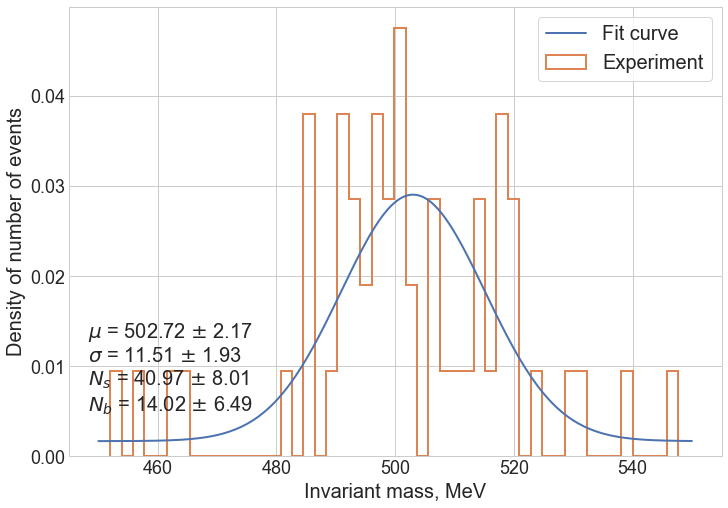

In [482]:
#get results
pars = result.params
errs = result.error()
mu_str = f"$\mu$ = {pars[mu]['value']:.2f} $\pm$ {errs[mu]['upper']:.2f}"
sigma_str = f"$\\sigma$ = {pars[sigma]['value']:.2f} $\pm$ {errs[sigma]['upper']:.2f}"
nsig_str = f"$N_s$ = {pars[Nsig]['value']:.2f} $\pm$ {errs[Nsig]['upper']:.2f}"
nbkg_str = f"$N_b$ = {pars[Nbkg]['value']:.2f} $\pm$ {errs[Nbkg]['upper']:.2f}"

#plot
x_dat = np.linspace(450, 550, 200)
y_dat = zfit.run(pdf.pdf(x_dat, norm_range=x))

plt.plot(x_dat, y_dat, label="Fit curve", lw=2)
plt.hist(dic[i], bins=50, histtype='step', density=True, label="Experiment", lw=2);

ax = plt.gca()
ax.tick_params(labelsize=18)
plt.ylabel("Density of number of events", fontsize=20);
plt.xlabel("Invariant mass, MeV", fontsize=20);
plt.legend(fontsize=20, loc='upper right', frameon=True);

#print parameters
param_str = f"{mu_str}\n{sigma_str}\n{nsig_str}\n{nbkg_str}"
ax.text(0.03, 0.1, param_str, fontsize=20, transform=ax.transAxes);

#write to table
N_dic[i] = [pars[Nsig]['value'], errs[Nsig]['upper']]

In [483]:
N_dic

{537.5: [1920.0893393887686, 44.957609169086005],
 550.0: [1302.2970303486961, 37.39409448136869],
 562.5: [642.7420149866471, 26.294319051272232],
 575.0: [493.24693082277264, 23.055131176339682],
 587.5: [355.9402691929715, 19.849109801999603],
 600.0: [257.1483843453737, 17.039607997968595],
 612.5: [244.81466694592567, 16.55842540635719],
 625.0: [183.03132751657205, 14.482738642702797],
 637.5: [120.60326462366332, 11.783683845728271],
 641.0: [787.651564755753, 29.88030784360008],
 650.0: [92.59053270798005, 10.353576839004337],
 675.0: [91.69672962536345, 10.080029711145947],
 687.5: [73.8437944738201, 9.43833845240562],
 700.0: [47.4095463668087, 7.607920200004074],
 712.5: [64.42997732609092, 9.075207931885311],
 725.0: [67.21316565141986, 8.861762442761867],
 737.5: [60.015372937430655, 8.15844962787485],
 750.0: [115.37370623632867, 11.437806078960836],
 762.0: [164.48807948455234, 14.06287889567898],
 775.0: [118.22704398406665, 12.270173028125457],
 787.5: [223.77812722802

### Some notes:

11 { (600, 687.5, 725, 812.5) - only gauss,    (700, 737.5 : 20 bins; 880, 950 : 15 bins) }

12 { ( 910 :15 bins)}

17 { (725, 825, 880) - only gauss, (900 : 11 bins, 960 : 8 bins), 990 - govno }

In [124]:
#mt.matrix(correlation=True)
#mt.draw_profile('Nsig');

In [511]:
dataN = pd.DataFrame(N_dic)
dataN = dataN.T
dataN.columns = ['Nsig', 'dNsig']

In [513]:
dataN.tail()

,Nsig,dNsig
936.0,21.970353,5.916780
950.0,74.961561,14.766347
962.5,33.947956,7.334400
975.0,5.687812,3.840555
987.5,40.973841,8.007605


I have got table with events numbers

Now, I will get rid of m-field in the data table (because, I have used it)

In [514]:
data_info = data.drop_duplicates(['lum']).drop(['mass', 'trigger'], axis=1)

In [515]:
dataN = dataN.join(data_info, how='inner')
dataN

,Nsig,dNsig,lum_err,lum,dEmin,dEmax,Emean
537.5,1920.089339,44.957609,1.75856,1224.660,0.00,0.00,537.45
550.0,1302.297030,37.394094,1.93920,1424.270,0.00,0.00,549.34
562.5,642.742015,26.294319,1.70440,1048.680,0.00,0.00,562.50
575.0,493.246931,23.055131,1.74597,1054.350,0.00,0.00,574.86
587.5,355.940269,19.849110,1.87792,1167.380,0.00,0.00,587.73
600.0,257.148384,17.039608,1.90969,1161.830,0.00,0.00,599.89
612.5,244.814667,16.558425,1.86299,1059.040,0.00,0.00,612.61
625.0,183.031328,14.482739,1.92848,1091.900,0.00,0.00,624.61
637.5,120.603265,11.783684,1.90042,1021.190,0.00,0.00,637.05
641.0,787.651565,29.880308,4.74255,12582.740,14.16,14.15,626.77


OK, save it

In [129]:
dataN.to_csv('out'+year+'.csv', float_format='%.2f')

Ok, now about triggers

In [ ]:
triggers = data[['trigger']]
triggers['one'] = 1;

In [ ]:
triggers = pd.pivot_table(triggers, values='one', columns=['trigger'], index='label', aggfunc=np.sum).fillna(0)

In [ ]:
triggers.columns = ['TF', 'CF', 'TC']

In [ ]:
triggers.head()

In [ ]:
def variance(k, n):
    return (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2

In [ ]:
triggers['eTF'] = (triggers['TC'] + 1)/(triggers['CF'] + triggers['TC'] + 2)
triggers['eCF'] = (triggers['TC'] + 1)/(triggers['TF'] + triggers['TC'] + 2)
triggers['TrigEff'] = 1 - (1-triggers['eTF'])*(1-triggers['eCF'])

triggers['vTF'] = np.sqrt( variance(triggers['TC'], triggers['CF'] + triggers['TC']) )
triggers['vCF'] = np.sqrt( variance(triggers['TC'], triggers['TF'] + triggers['TC']) )
triggers['TrigErr'] = np.sqrt( np.square((1-triggers['eTF'])*triggers['vCF']) + 
                              np.square((1-triggers['eCF'])*triggers['vTF']) )

OK, trigers have been got

In [ ]:
triggers.to_csv('triggers'+year+'.csv', float_format='%.2f')

In [ ]:
triggers